## Table of Content


1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)<br>
3. [Data Visualization](#section3)<br>
    - 3.1  [Over-view of Data-set](#section301)<br>
    - 3.2  [General Comparision between Infected v/s Unfected Cells](#section302)<br>
    - 3.3  [Identifying Dark Spots](#section303)<br>
    - 3.4  [Blob Detection](#section304)<br>
    - 3.5  [Adding labels](#section305)<br>
4. [Splitting Test and  Train data](#section4)<br>
5. [Multi Layer Perceptron Neural Network](#section5)<br>
    - 5.1 [Model 1](#section501)<br>
    - 5.2 [Model 2](#section502)<br>

 <a id=section1></a>

### Problem Statement 

__Malaria__ is a mosquito-borne infectious disease that affects humans and other animals. Malaria causes symptoms that typically include fever, tiredness, vomiting, and headaches. In severe cases it can cause yellow skin, seizures, coma, or death. Symptoms usually begin ten to fifteen days after being bitten by an infected mosquito. If not properly treated, people may have recurrences of the disease months later. In those who have recently survived an infection, reinfection usually causes milder symptoms. This partial resistance disappears over months to years if the person has no continuing exposure to malaria.
![alt text](https://oxfordmartin.imgix.net/_originals/Artboard%2093-100.jpg?w=710&h=399&fit=crop)

As a part of our job as a data analyst, we classified  data into two classes __Infected and Uninfected cells__.

 <a id=section2></a>

### 2. Data Loading and Description

In [1]:
#details of cpu and gpu allocated by colab
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14090766804379373633, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12490519469554647571
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2248111541027323716
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13982911464253296318
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization,Conv2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
#packages for giving authorization to 
#share resources between google drive and colab

!pip install PyDrive #bash command: installs PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#drive to colab user authentication
#allow the authentication requests
#copy paste verification code provided by the link generated

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Steps to upload files in google drive:

- archive files (for faster uploads of larger files) (tar, zip, rar)
- upload the archived files to google drive
- create a sharable link 
- copy only sharable link's id

https://drive.google.com/file/d/1Bk1CjyeO4fNMIp7lGBK5HGmqTrihv7dT/view?usp=sharing

In [0]:
#copy the sharable id and paste below 

download = drive.CreateFile({'id': '1Bk1CjyeO4fNMIp7lGBK5HGmqTrihv7dT'})
download.GetContentFile('cell_images.tar')

In [0]:
#uploads the shared file to colab hosted machine
#files are stored in hosted machine disk storage
#above GetContentFile and below SetContentFile should be same
#CreateFile saves the uploaded file as name given in title

upload = drive.CreateFile({'title': 'cell_images.tar'})
upload.SetContentFile('cell_images.tar')
upload.Upload()

Since google colab is debian based server. 
We can use bash commands to navigate through the allocated disk

In [8]:
#current directory
#current directory should be content
#this is were data is stored for colab to access
!pwd

/content


In [9]:
#lists contents of current directory
#this shows our uploaded archived file (if not repeat the upload process)
!ls

adc.json  cell_images  cell_images.tar	Cells.npy  Labels.npy  sample_data


In [10]:
#extracts the archived files
!tar -xvf cell_images.tar

./cell_images/
./cell_images/Parasitized/
./cell_images/Parasitized/C119P80ThinF_IMG_20151002_124425_cell_133.png
./cell_images/Parasitized/C84P45ThinF_IMG_20150818_101146_cell_85.png
./cell_images/Parasitized/C97P58ThinF_IMG_20150917_150838_cell_165.png
./cell_images/Parasitized/C118P79ThinF_IMG_20151002_105018_cell_148.png
./cell_images/Parasitized/C184P145ThinF_IMG_20151203_103114_cell_158.png
./cell_images/Parasitized/C133P94ThinF_IMG_20151004_155721_cell_110.png
./cell_images/Parasitized/C175P136NThinF_IMG_20151127_142326_cell_228.png
./cell_images/Parasitized/C70P31_ThinF_IMG_20150813_131457_cell_17.png
./cell_images/Parasitized/C59P20thinF_IMG_20150803_113809_cell_5.png
./cell_images/Parasitized/C60P21thinF_IMG_20150803_144629_cell_5.png
./cell_images/Parasitized/C137P98ThinF_IMG_20151005_161306_cell_3.png
./cell_images/Parasitized/C182P143NThinF_IMG_20151201_172524_cell_204.png
./cell_images/Parasitized/C116P77ThinF_IMG_20150930_171219_cell_109.png
./cell_images/Parasitized/C13

In [11]:
#new folder with name of archived file should appear
!ls


adc.json  cell_images  cell_images.tar	Cells.npy  Labels.npy  sample_data


In [12]:
# We have two image data-sets infected and uninfected  


print(os.listdir("./cell_images"))

['Parasitized', 'Uninfected']


In [0]:
infected = os.listdir('./cell_images/Parasitized/') 
uninfected = os.listdir('./cell_images/Uninfected/')

In [14]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("./cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated90 = resize_img.rotate(90)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated90))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread("./cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated90 = resize_img.rotate(90)
        data.append(np.array(resize_img))
        data.append(np.array(rotated90))
        data.append(np.array(blur))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

In [0]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [16]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (82674, 50, 50, 3) | labels : (82674,)


___

 <a id=section3></a>

### 3. Data Visualization

 <a id=section301></a>

__Over-view of Data-set__

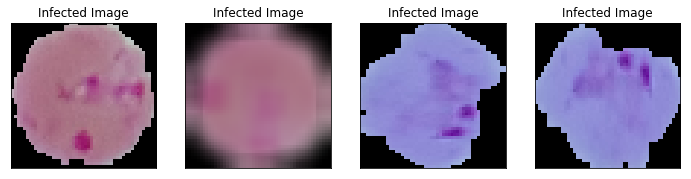

In [17]:
plt.figure(figsize=(12,5))
for i in range(1,5):
    plt.subplot(1,4,i)
    #value = np.random.randint(0 , cells.shape[60000] , 1)
    plt.imshow(cells[6000 + i])
    plt.title('Infected Image')
    plt.xticks([])
    plt.yticks([])

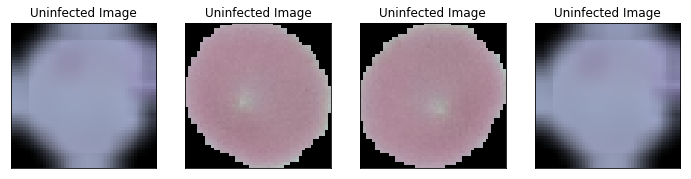

In [18]:
plt.figure(figsize=(12,5))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(cells[70000 + i])
    plt.title('Uninfected Image')
    plt.xticks([])
    plt.yticks([])

___

 <a id=section302></a>

__General Comparision between Infected v/s Unfected Cells__

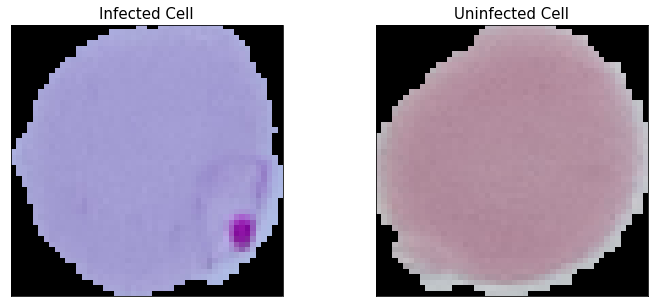

In [19]:
plt.figure(1, figsize = (12 , 5))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[7000])
plt.title('Infected Cell',fontsize=15)
plt.xticks([]) 
plt.yticks([])


plt.subplot(1 , 2 , 2)
plt.imshow(cells[75000])
plt.title('Uninfected Cell',fontsize=15)
plt.xticks([]) 
plt.yticks([])

plt.show()

___

 <a id=section303></a>

__Identifying Dark Spots:__

We will now try to identify dark spots in the image. We do this because we know that the infected part of the cell is, in general, darker than the rest of the cell. Thus, this infected part might appear as a dark spot on the cell.

We use the skimage function 'black_tophat' which returns an image containing dark spots of the image (refer to http://scikit-image.org/docs/dev/api/skimage.morphology.html ). These dark spots appear as bright spots in the returned image.

In [0]:
import skimage.morphology as skm
def dark_spots(sample,title='',to_return=False):
    black_tophat=skm.black_tophat(sample)
    black_tophat_refined=skm.black_tophat(black_tophat)
    black_tophat_refined=skm.black_tophat(black_tophat_refined)
    if(to_return==True):
        return black_tophat_refined
    
    fig=plt.figure(figsize=(14,5))
    plt.title(title+'\n',fontsize=20)
    plt.axis('off')
    ax1=fig.add_subplot(131)
    ax1.imshow(sample)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("Image",fontsize=15)
    ax2=fig.add_subplot(132)
    ax2.imshow(black_tophat)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("Dark Spots",fontsize=15)
    ax3=fig.add_subplot(133)
    ax3.imshow(black_tophat_refined)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title("Refined Dark Spots",fontsize=15)
    plt.show()

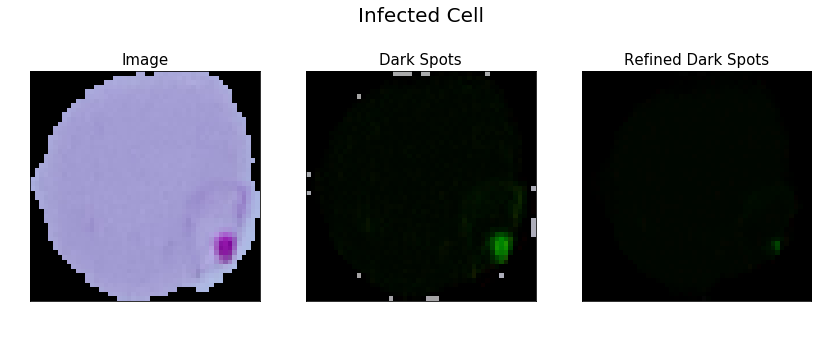

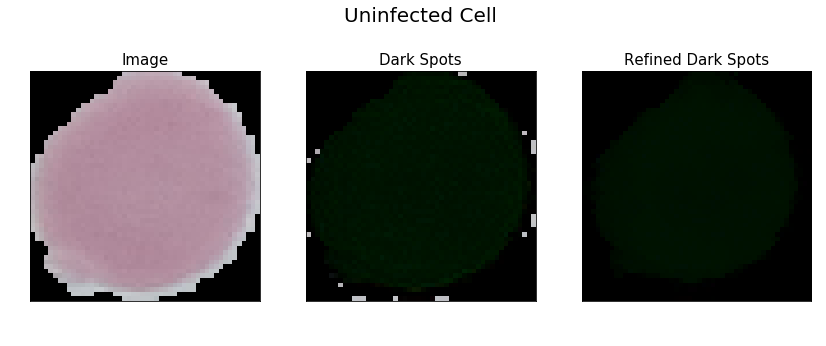

In [21]:
dark_spots(cells[7000],"Infected Cell")
dark_spots(cells[75000],"Uninfected Cell")

When we apply black_tophat once, we realize numerous number of white spots on the outline of the image. These maybe caused because of numerous, tiny, very dark spots on top of the cell boundary. To remove these spots, we apply black_tophat twice, to ensure that the very bright spots don't appear in the final image.

___

 <a id=section304></a>

__Blob Detection:__

Blob Detection is an algorithm to detect blobs in the image. Blobs are similar to spots. When we looked at the infected and uninfected images, one can easily observe that almost all infected cells had 'blobs' in them, while almost none of the uninfected cells had these blobs. Thus, we can simplify the problem to identifying whether a cell has a blob in it. If yes, then it might be infected, else it might be uninfected.

In [0]:
from skimage.feature import blob_dog,blob_log,blob_doh
from skimage.color import rgb2gray
def identify_blobs(sample,title='',to_return=False,threshold=2.5*1e-9):
    spots=dark_spots(sample,to_return=True)
    gray_spots=rgb2gray(spots)
    final_spots=skm.white_tophat(gray_spots,selem=skm.square(10))
    log=blob_doh(final_spots,threshold=threshold,min_sigma=10,max_sigma=50)
    if(to_return==True):
        return log
    
    fig=plt.figure(figsize=(12,7))
    plt.title(title,fontsize=20)
    plt.axis('off')
    ax1=fig.add_subplot(121)
    ax1.imshow(final_spots,cmap='gray')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("Cleaned Grayscale Image",fontsize=15)
    ax2=fig.add_subplot(122)
    ax2.imshow(sample)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("Location of Blobs",fontsize=15)
    plt.xticks
    plt.show()
    


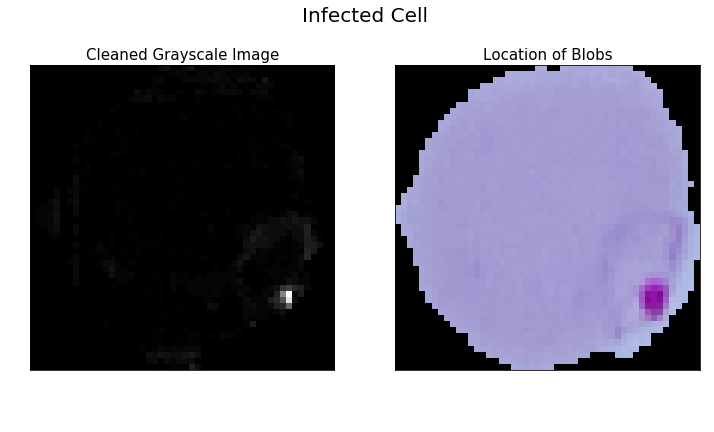

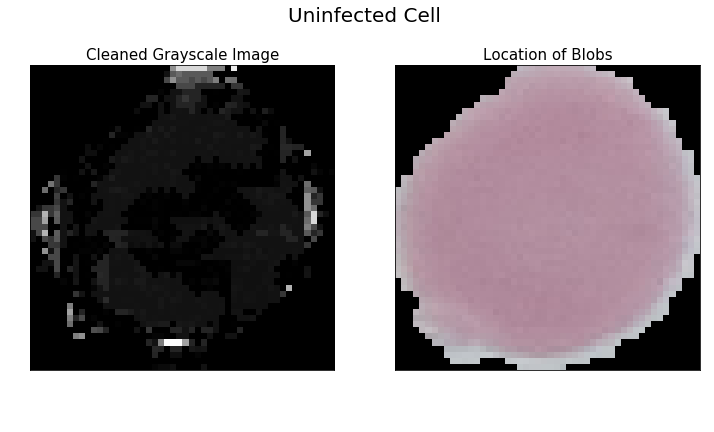

In [23]:
identify_blobs(cells[7000],"Infected Cell")
identify_blobs(cells[75000],"Uninfected Cell")

We use the dark spots function mentioned above as it provides a very clean image where blobs, if any, can be distinguished easily. Skimage has three blob detection features - blob_dog, blob_log and blob_doh. Blob_dog is the most accurate and slowest, while blob_doh is less accurate but fast (Refer to http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html ). We'll use blob_doh now to save time.

___

 <a id=section305></a>

__Adding labels =>__  Infected : __1__ ; Uninfected: __0__

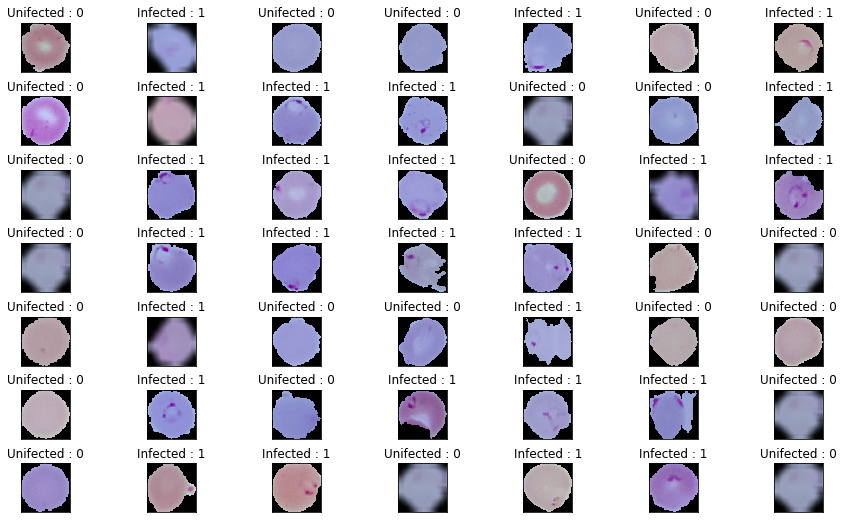

In [24]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

___

 <a id=section4></a>

### Splitting Data-set into Train and Test

In [0]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]


cells = cells.astype(np.float32)
labels = labels.astype(np.int32)

In [0]:
from sklearn.model_selection import train_test_split

train_x , test_x , train_y , test_y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 100)


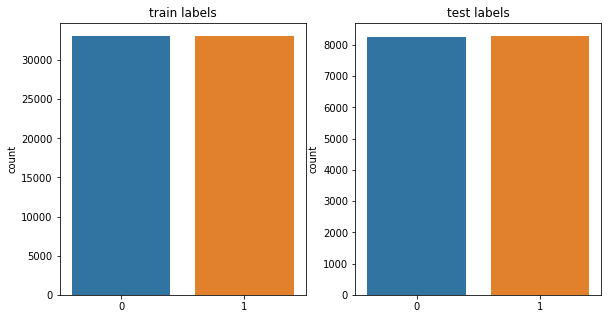

In [27]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , test_y] , ['train labels', 'test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [28]:
print('train data shape {} , test data shape {}'.format(train_x.shape, test_x.shape))

train data shape (66139, 50, 50, 3) , test data shape (16535, 50, 50, 3)


___

 <a id=section5></a>

### Multi Layer Perceptron Neural Network

__Convolutional Neural Network (CNN) :__

In neural networks, __Convolutional neural network (ConvNets or CNNs)__ is one of the main categories to do images recognition, images classifications. Objects detections, recognition faces etc., are some of the areas where CNNs are widely used.

CNN image classifications takes an input image, process it and classify it under certain categories (Eg. Infected and Uninfected cells). Computers sees an input image as array of pixels and it depends on the image resolution. Based on the image resolution, it will see __h x w x d( h = Height, w = Width, d = Dimension )__. Eg., An image of 6 x 6 x 3 array of matrix of RGB (3 refers to RGB values) and an image of 4 x 4 x 1 array of matrix of grayscale image.

![alt text](https://cdn-images-1.medium.com/max/1200/1*CBY94wikMUCZMB4-Xxs-pw.png)

The below figure is a complete flow of CNN to process an input image and classifies the objects based on values:

![alt text](https://cdn-images-1.medium.com/max/800/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)

Convolution is the first layer to extract features from an input image. Convolution preserves the relationship between pixels by learning image features using small squares of input data. It is a mathematical operation that takes two inputs such as image matrix and a filter or kernal.
![alt text](https://cdn-images-1.medium.com/max/800/1*kYSsNpy0b3fIonQya66VSQ.png)

Consider a 5 x 5 whose image pixel values are 0, 1 and filter matrix 3 x 3 as shown in below:

![alt text](https://cdn-images-1.medium.com/max/800/1*4yv0yIH0nVhSOv3AkLUIiw.png)
Then the convolution of 5 x 5 image matrix multiplies with 3 x 3 filter matrix which is called __“Feature Map”__ as output shown in below:

![alt text](https://cdn-images-1.medium.com/max/800/1*MrGSULUtkXc0Ou07QouV8A.gif)

Convolution of an image with different filters can perform operations such as edge detection, blur and sharpen by applying filters.

__Fully Connected Layer__

The layer we call as FC layer, we flattened our matrix into vector and feed it into a fully connected layer like neural network.

![alt text](https://cdn-images-1.medium.com/max/800/1*Mw6LKUG8AWQhG73H1caT8w.png)

![alt text](https://cdn-images-1.medium.com/max/800/1*4GLv7_4BbKXnpc6BRb0Aew.png)

 <a id=section501></a>

#### Model 1

In [0]:
model1 = Sequential()
model1.add(Convolution2D(32,(5,5),activation='tanh',input_shape = (50, 50, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.2))
model1.add(Convolution2D(32,(5,5),activation='tanh'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.2))
model1.add(Convolution2D(64,(5,5),activation='tanh'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(64,activation='tanh'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 32)        2432      
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_8 (Batch (None, 19, 19, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 32)          0         
__________

In [0]:
# set early stopping monitor
early_stopping_monitor = EarlyStopping(patience = 3) 

In [62]:
cnn1 = model1.fit(train_x, train_y, epochs = 20, validation_split = 0.2, callbacks = [early_stopping_monitor])

Train on 52911 samples, validate on 13228 samples
Epoch 1/20
52911/52911 [==============================] - 16s 298us/step - loss: 0.4623 - acc: 0.7560 - val_loss: 0.4806 - val_acc: 0.7942
Epoch 2/20
52911/52911 [==============================] - 14s 274us/step - loss: 0.2723 - acc: 0.8874 - val_loss: 1.7111 - val_acc: 0.5036
Epoch 3/20
52911/52911 [==============================] - 15s 277us/step - loss: 0.2464 - acc: 0.9034 - val_loss: 0.2811 - val_acc: 0.8930
Epoch 4/20
52911/52911 [==============================] - 15s 289us/step - loss: 0.4887 - acc: 0.7086 - val_loss: 0.5662 - val_acc: 0.6615
Epoch 5/20
52911/52911 [==============================] - 15s 275us/step - loss: 0.4646 - acc: 0.7236 - val_loss: 0.6522 - val_acc: 0.6389
Epoch 6/20
52911/52911 [==============================] - 15s 275us/step - loss: 0.4491 - acc: 0.7442 - val_loss: 0.4530 - val_acc: 0.7749


In [0]:
y_pred1 = model1.predict(test_x)

In [64]:
loss_and_metrics = model1.evaluate(test_x, test_y)

16535/16535 [==============================] - 1s 90us/step


In [65]:
from sklearn.metrics import classification_report,confusion_matrix

print("Confussion Matrix: ")
cm=np.array(confusion_matrix(test_y , y_pred1.round()))
confusion = pd.DataFrame(cm, index=["Uninfected", "Infected"],
                         columns=["predicted_uninfected", "predicted_infected"])
confusion


Confussion Matrix: 


,predicted_uninfected,predicted_infected
Uninfected,7271,973
Infected,2772,5519


In [66]:
 print("Classification Report: ")
print(classification_report(test_y ,  y_pred1.round()))

Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.88      0.80      8244
           1       0.85      0.67      0.75      8291

   micro avg       0.77      0.77      0.77     16535
   macro avg       0.79      0.77      0.77     16535
weighted avg       0.79      0.77      0.77     16535



In [67]:
accuracy = round((cm[0,0]+cm[1,1])/cm.sum(),3)
print('Accuracy = {:0.2f}%.'.format(100 * accuracy))

Accuracy = 77.40%.


In [68]:
cost= round((cm[0,0]* 0)+(cm[1,0]* 100)+ (cm[1,1]* -1)+ (cm[0,1]*1))
print("Misclassification Cost of the above model is",cost,".")

Misclassification Cost of the above model is 272654 .


In [0]:
values1  = cnn1.history
validation_loss = values1['val_loss']
validation_acc = values1['val_acc']
training_acc = values1['acc']
training_loss = values1['acc']
epochs= range(6)

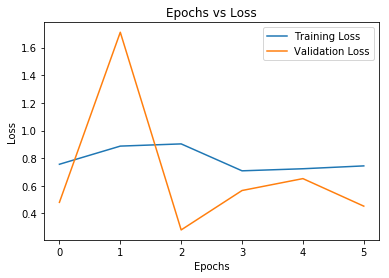

In [70]:
plt.plot(epochs,training_loss,label = 'Training Loss')
plt.plot(epochs,validation_loss,label = 'Validation Loss')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()
plt.show()

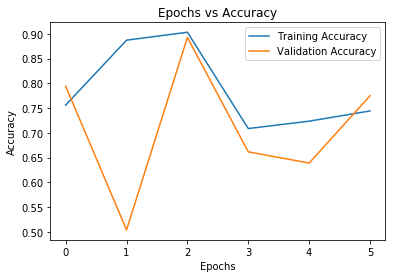

In [71]:
plt.plot(epochs,training_acc,label = 'Training Accuracy')
plt.plot(epochs,validation_acc,label = 'Validation Accuracy')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

___

 <a id=section502></a>

#### Model 2

In [0]:
model2 = Sequential()
model2.add(Convolution2D(32,(3,3),activation='relu',input_shape = (50,50,3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.2))
model2.add(Convolution2D(32,(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.2))
model2.add(Convolution2D(64,(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [73]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 22, 22, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 32)        0         
__________

In [74]:
# train model 
cnn2 = model2.fit(train_x, train_y, epochs = 20, validation_split = 0.2, callbacks = [early_stopping_monitor])


Train on 52911 samples, validate on 13228 samples
Epoch 1/20
52911/52911 [==============================] - 16s 311us/step - loss: 0.2043 - acc: 0.9161 - val_loss: 0.1197 - val_acc: 0.9574
Epoch 2/20
52911/52911 [==============================] - 14s 268us/step - loss: 0.1185 - acc: 0.9604 - val_loss: 0.1288 - val_acc: 0.9562
Epoch 3/20
52911/52911 [==============================] - 14s 268us/step - loss: 0.1084 - acc: 0.9655 - val_loss: 0.1295 - val_acc: 0.9580
Epoch 4/20
52911/52911 [==============================] - 14s 267us/step - loss: 0.1020 - acc: 0.9679 - val_loss: 0.1678 - val_acc: 0.9638


In [0]:
y_pred2 = model2.predict(test_x)

In [76]:
loss_and_metrics = model2.evaluate(test_x, test_y)

16535/16535 [==============================] - 1s 85us/step


In [77]:

print("Confussion Matrix: ")
cm=np.array(confusion_matrix(test_y , y_pred2.round()))
confusion = pd.DataFrame(cm, index=["Uninfected", "Infected"],
                         columns=["predicted_uninfected", "predicted_infected"])
confusion






Confussion Matrix: 


,predicted_uninfected,predicted_infected
Uninfected,8096,148
Infected,390,7901


In [78]:
print("Classification Report: ")
print(classification_report(test_y ,  y_pred2.round()))

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8244
           1       0.98      0.95      0.97      8291

   micro avg       0.97      0.97      0.97     16535
   macro avg       0.97      0.97      0.97     16535
weighted avg       0.97      0.97      0.97     16535



In [79]:
accuracy = round((cm[0,0]+cm[1,1])/cm.sum(),3)
print('Accuracy = {:0.2f}%.'.format(100 * accuracy))

Accuracy = 96.70%.


In [80]:
cost= round((cm[0,0]* 0)+(cm[1,0]* 100)+ (cm[1,1]* -1)+ (cm[0,1]*1))
print("Misclassification Cost of the above model is",cost,".")

Misclassification Cost of the above model is 31247 .


In [0]:
values2  = cnn2.history
validation_loss = values2['val_loss']
validation_acc = values2['val_acc']
training_acc = values2['acc']
training_loss = values2['acc']
epochs = range(4)

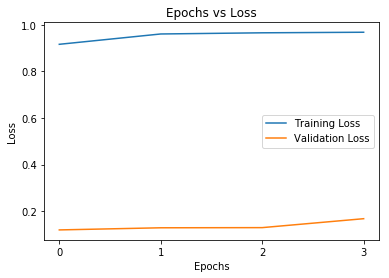

In [84]:
plt.plot(epochs,training_loss,label = 'Training Loss')
plt.plot(epochs,validation_loss,label = 'Validation Loss')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()
plt.show()

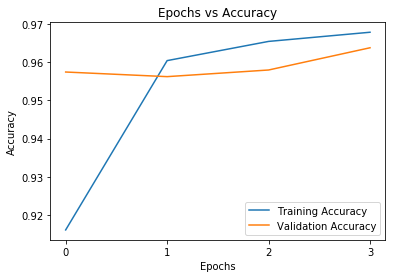

In [85]:
plt.plot(epochs,training_acc,label = 'Training Accuracy')
plt.plot(epochs,validation_acc,label = 'Validation Accuracy')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

___